# 随机激光光谱深度学习Keras
1.14

## 导入所需的库

In [1]:
import graphviz
import keras.backend
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import *
from keras.losses import mean_squared_error
from keras.models import *
from keras.utils import plot_model
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import pydot_ng as pydot
from tensorflow.keras.utils import plot_model
import cv2
np.random.seed(10)

Using TensorFlow backend.


# 1 Peak Prediciton

## 导入光谱数据

In [2]:
# 输入数据
sum_data = np.load("mod5000.npy")
x = np.load("x.npy")

In [3]:
sum_data.shape

(43, 5000)

Text(0.5, 1.0, 'Spectrum')

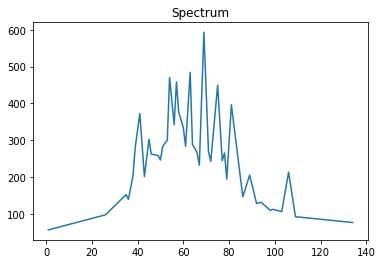

In [4]:
# 作图查看
plt.figure()
plt.plot(x,sum_data[:,1])
plt.title("Spectrum")

# 取点
# [start, end] = plt.ginput(2)
# x1, y1 = start[0], start[1]
# x2, y2 = end[0], end[1]

In [5]:
# 保留光谱值并竖向转置
DataY = sum_data.T
frame = DataY.shape[0]
frame, DataY.shape

(5000, (5000, 43))

## 光谱归一化与标准化的对比

In [39]:
# Z-Score标准化的评估器实现方法  均按列转换

X = DataY  # 导入数据
scaler = StandardScaler()
train_x, test_x = train_test_split(
    X, train_size=int(0.8 * frame), test_size=int(0.2 * frame), shuffle=False
)

# scaler.inverse_transform() 逆转换

# 一步执行在X_train上fit和transfrom两个操作
scaler = StandardScaler()
train_x_col_std = scaler.fit_transform(train_x)
test_x_col_std = scaler.fit_transform(test_x.T).T 

train_x_row_std = scaler.fit_transform(train_x.T).T
test_x_row_std = scaler.fit_transform(
    test_x.T
).T  # 非通道，若以训练集的均值和标准差转换测试集--scaler.tansform,

# 赋值替代
train_x = train_x_row_std
test_x = test_x_row_std

In [40]:
train_frame = train_x.shape[0]
test_frame = test_x.shape[0]
train_frame, test_frame

(4000, 1000)

Text(0.5, 1.0, 'Standardization Spectrum')

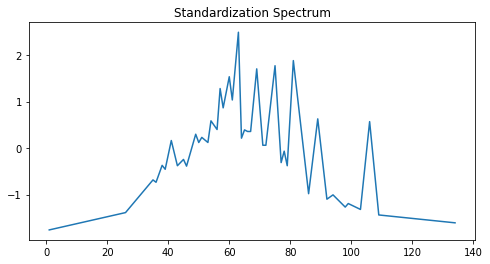

In [41]:
# 作图查看
plt.figure(figsize=(8, 4))
plt.plot(x,train_x[0, :])  # 第一行
plt.title("Standardization Spectrum")

## 分离单一波长

In [42]:
# 分批次
l=DataY.shape[1]
predict_step=3
time_step = l-predict_step   #16 32
predict_index=20

train_X = np.expand_dims(np.concatenate((train_x[:, :predict_index], train_x[:, predict_index+1:l]), axis=1),axis=1) 
train_Y = np.expand_dims(np.expand_dims(train_x[:, predict_index],axis=1) ,axis=1) 
print(train_X.shape)
print(train_Y.shape)

(4000, 1, 42)
(4000, 1, 1)


In [43]:
test_X = np.expand_dims(np.concatenate((test_x[:, :predict_index], test_x[:, predict_index+1:l]), axis=1),axis=1) 
test_Y = np.expand_dims(np.expand_dims(test_x[:, predict_index],axis=1) ,axis=1) 
print(test_X.shape)
print(test_Y.shape)

(1000, 1, 42)
(1000, 1, 1)


## 构建神经网络层 DNN

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 42)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1, 128)            5504      
_________________________________________________________________
dense_14 (Dense)             (None, 1, 8)              1032      
_________________________________________________________________
dense_15 (Dense)             (None, 1, 32)             288       
_________________________________________________________________
dense_16 (Dense)             (None, 1, 1)              33        
Total params: 6,857
Trainable params: 6,857
Non-trainable params: 0
_________________________________________________________________


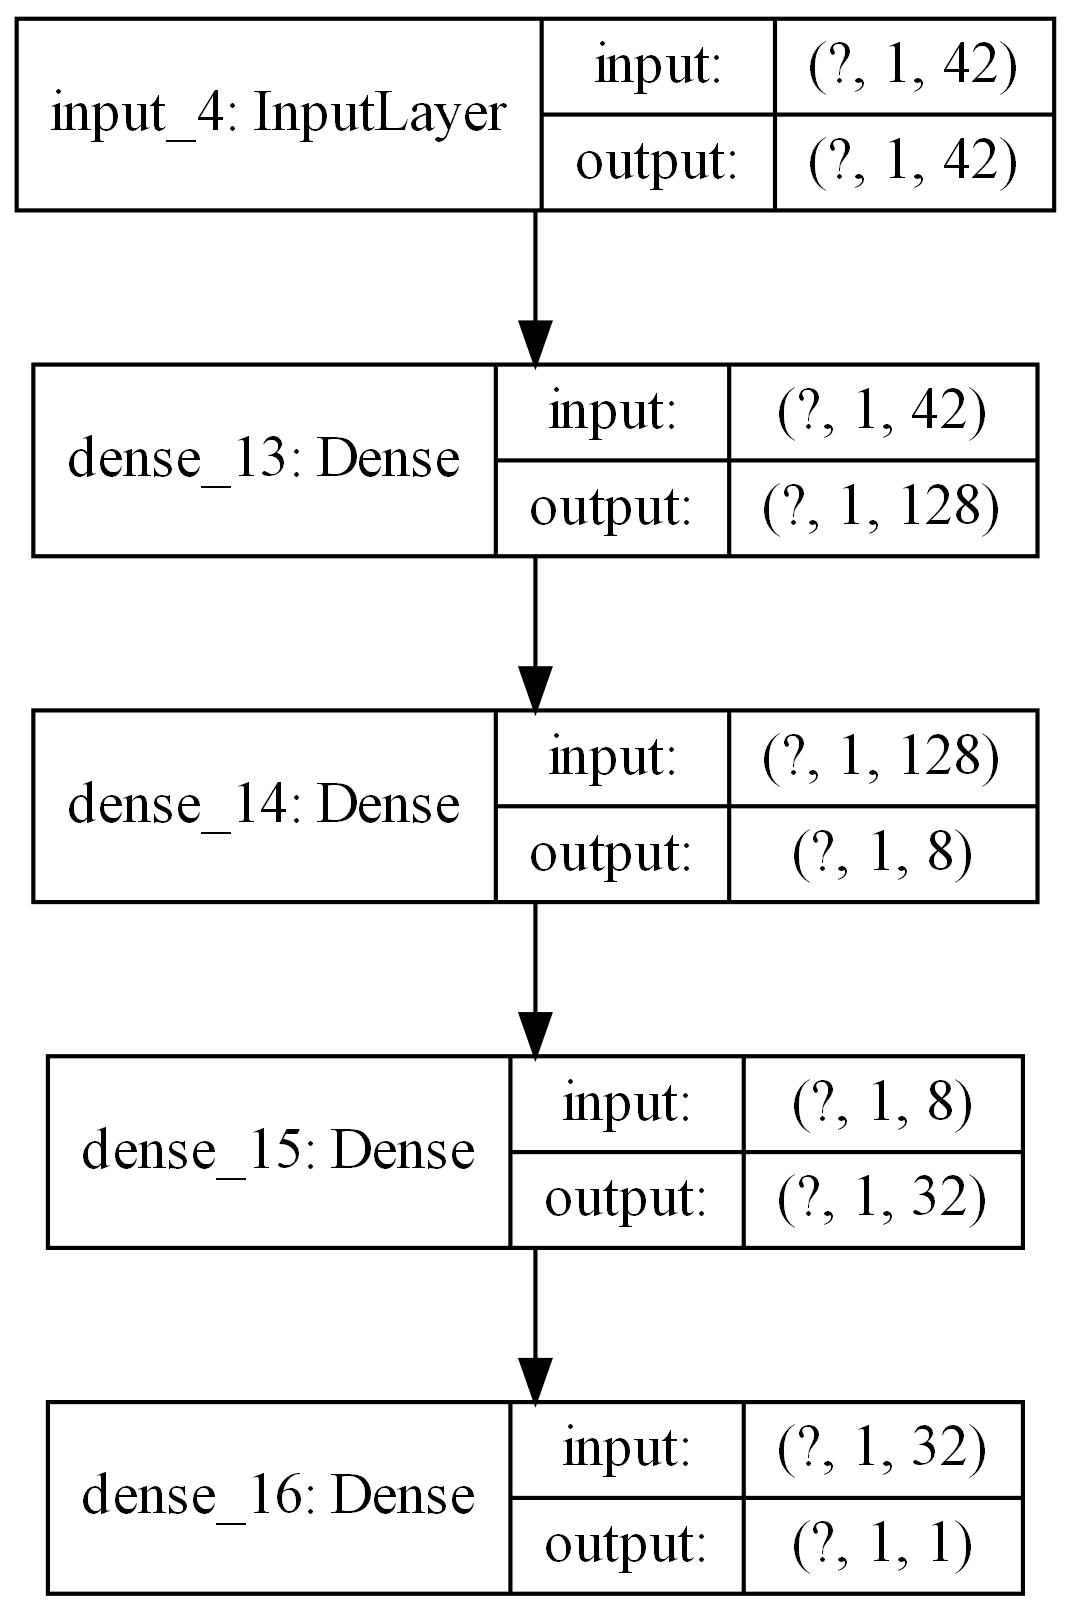

In [44]:
# Model式
lstm_units = 128
dropout = 0.1
pool_size=2

inputs = Input(shape=(1,42))

# Dense compasion
model = Dense(128)(inputs) 
model = Dense(8)(model) 
model = Dense(32)(model) 
predictions=Dense(1, activation="elu")(model)  # mape 39

# 多个Dense1输出，效果一般
# predictions=[]
# model = Add()([model,lambda_sum]) #activation="softmax"
# for i in range(numChannels):
#     x=Dense(1,name='Dense{}'.format(i+1))(model)
#     predictions.append(x)
# predictions = Lambda(lambda x:keras.backend.concatenate(x, axis=1))(predictions)

model = Model(inputs=inputs, outputs=predictions)

# 配置训练模型
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
# 优化器选择：SGD,RMSprop,Adam,AdamW,Adadelta,Adagrad,Adamax,Adafactor,Nadam,Ftrl
model.summary()  # 展示模型结构

plot_model(model, show_shapes=True, show_layer_names=True,to_file='model_1peak.png',dpi=300)  # 展示输入输出表格

In [45]:
#设置回调
# TensorBoard = keras.callbacks.TensorBoard(histogram_freq=1,write_graph=True) # tensorboard --logdir=F:\MATLAB\MATLAB_Scripts\JupyterLab_Projects\logs --host=127.0.0.1

# def scheduler(epoch, lr):
#     if epoch < 5:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
# LearningRateScheduler=keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

# ReduceLROnPlateau=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)  #优化停止时减少学习率
# EarlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)  #早停

Train on 4000 samples, validate on 1000 samples
Epoch 1/15
 - 0s - loss: 0.3936 - accuracy: 0.0000e+00 - val_loss: 0.1735 - val_accuracy: 0.0000e+00
Epoch 2/15
 - 0s - loss: 0.1029 - accuracy: 0.0000e+00 - val_loss: 0.0584 - val_accuracy: 0.0000e+00
Epoch 3/15
 - 0s - loss: 0.0508 - accuracy: 0.0000e+00 - val_loss: 0.0478 - val_accuracy: 0.0000e+00
Epoch 4/15
 - 0s - loss: 0.0321 - accuracy: 0.0000e+00 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 5/15
 - 0s - loss: 0.0153 - accuracy: 0.0000e+00 - val_loss: 0.0154 - val_accuracy: 0.0000e+00
Epoch 6/15
 - 0s - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 7/15
 - 0s - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 8/15
 - 0s - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 9/15
 - 0s - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 10/15
 - 0s - loss: 0.0030 - accuracy

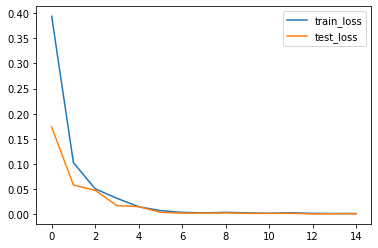

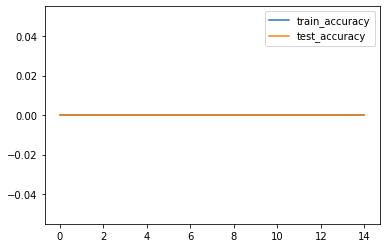

In [46]:
# 训练模型，以 xx 个样本为一个 batch 进行迭代
train = model.fit(
    train_X,
    train_Y,
    epochs=15,
    batch_size=32, # 16 32 64
    validation_data=(test_X, test_Y),
    verbose=2,
    shuffle=True,
    # callbacks=[TensorBoard]
)


# 可视化进度
plt.plot(train.history["loss"], label="train_loss")
plt.plot(train.history["val_loss"], label="test_loss")
plt.legend()
plt.show()

plt.plot(train.history["accuracy"], label="train_accuracy")
plt.plot(train.history["val_accuracy"], label="test_accuracy")
plt.legend()
plt.show()
# %load_ext tensorboard
# %tensorboard --logdir F:\MATLAB\MATLAB_Scripts\JupyterLab_Projects\logs

## 预测光谱数据

In [49]:
# np.save('train_Y_nostd',train_Y)
# from scipy import io
# mat=np.load('train_Y_nostd.npy')
# io.savemat('train_Y_nostd.mat', {'train_Y_nostd': mat})

In [50]:
# 在测试集上的预测
test_Y_predict = model.predict(test_X)
test_Y_predict.shape, test_Y.shape

((1000, 1, 1), (1000, 1, 1))

Text(0.5, 1.0, 'Test Data 1')

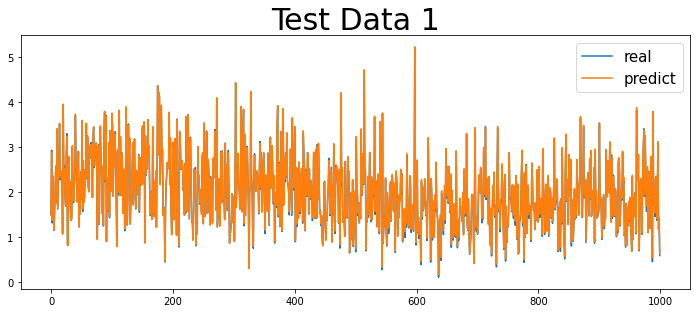

In [51]:
fig = plt.figure(figsize=(16,32))  # 宽，高
fig.subplots_adjust(hspace=0.3, wspace=0.1,top=3)  # 间距
plt.subplot(411)
draw = pd.concat([pd.DataFrame(test_Y[:,0, 0]), pd.DataFrame(test_Y_predict[:,0, 0])], axis=1)
draw.iloc[:, 0].plot(figsize=(12, 6))
draw.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 1", fontsize="30")  # 添加标题

In [52]:
# 输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# 平均绝对误差（Mean Absolute Error，MAE）

# 均方误差（Mean Square Error，MSE）
# 平均绝对百分比误差（Mean Absolute Percentage Error，MAPE）

y=np.squeeze(test_Y_predict)
Y=np.squeeze(test_Y)
print("测试集上的")
print(mean_absolute_error(y,Y))
print(mean_squared_error(y,Y))
print(np.sqrt(mean_squared_error(y,Y)))
print(mape(Y,y))

测试集上的
0.030985797712376258
0.0014965797740712566
0.038685653336492286
2.0236982905786634


# 3 Peaks Prediction

In [53]:
ss=np.delete(train_x,[15,20],axis=1)
ss.shape

(4000, 41)

In [54]:
# 分批次
l=DataY.shape[1]
predict_step=3
time_step = l-predict_step   #16 32
predict_index1,predict_index2,predict_index3=16,20,25

In [55]:
train_x.shape

(4000, 43)

In [56]:
np.delete(train_x,[predict_index1,predict_index2,predict_index3],axis=1).shape

(4000, 40)

In [57]:
train_X = np.expand_dims(np.delete(train_x,[predict_index1,predict_index2,predict_index3],axis=1),axis=1) 
train_Y = np.expand_dims(train_x[:, [predict_index1,predict_index2,predict_index3]],axis=1)
print(train_X.shape)
print(train_Y.shape)

(4000, 1, 40)
(4000, 1, 3)


In [58]:
test_X = np.expand_dims(np.delete(test_x,[predict_index1,predict_index2,predict_index3],axis=1),axis=1) 
test_Y = np.expand_dims(test_x[:, [predict_index1,predict_index2,predict_index3]],axis=1)
print(test_X.shape)
print(test_Y.shape)

(1000, 1, 40)
(1000, 1, 3)


## 构建神经网络层 DNN

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 40)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1, 128)            5248      
_________________________________________________________________
dense_18 (Dense)             (None, 1, 8)              1032      
_________________________________________________________________
dense_19 (Dense)             (None, 1, 32)             288       
_________________________________________________________________
dense_20 (Dense)             (None, 1, 3)              99        
Total params: 6,667
Trainable params: 6,667
Non-trainable params: 0
_________________________________________________________________


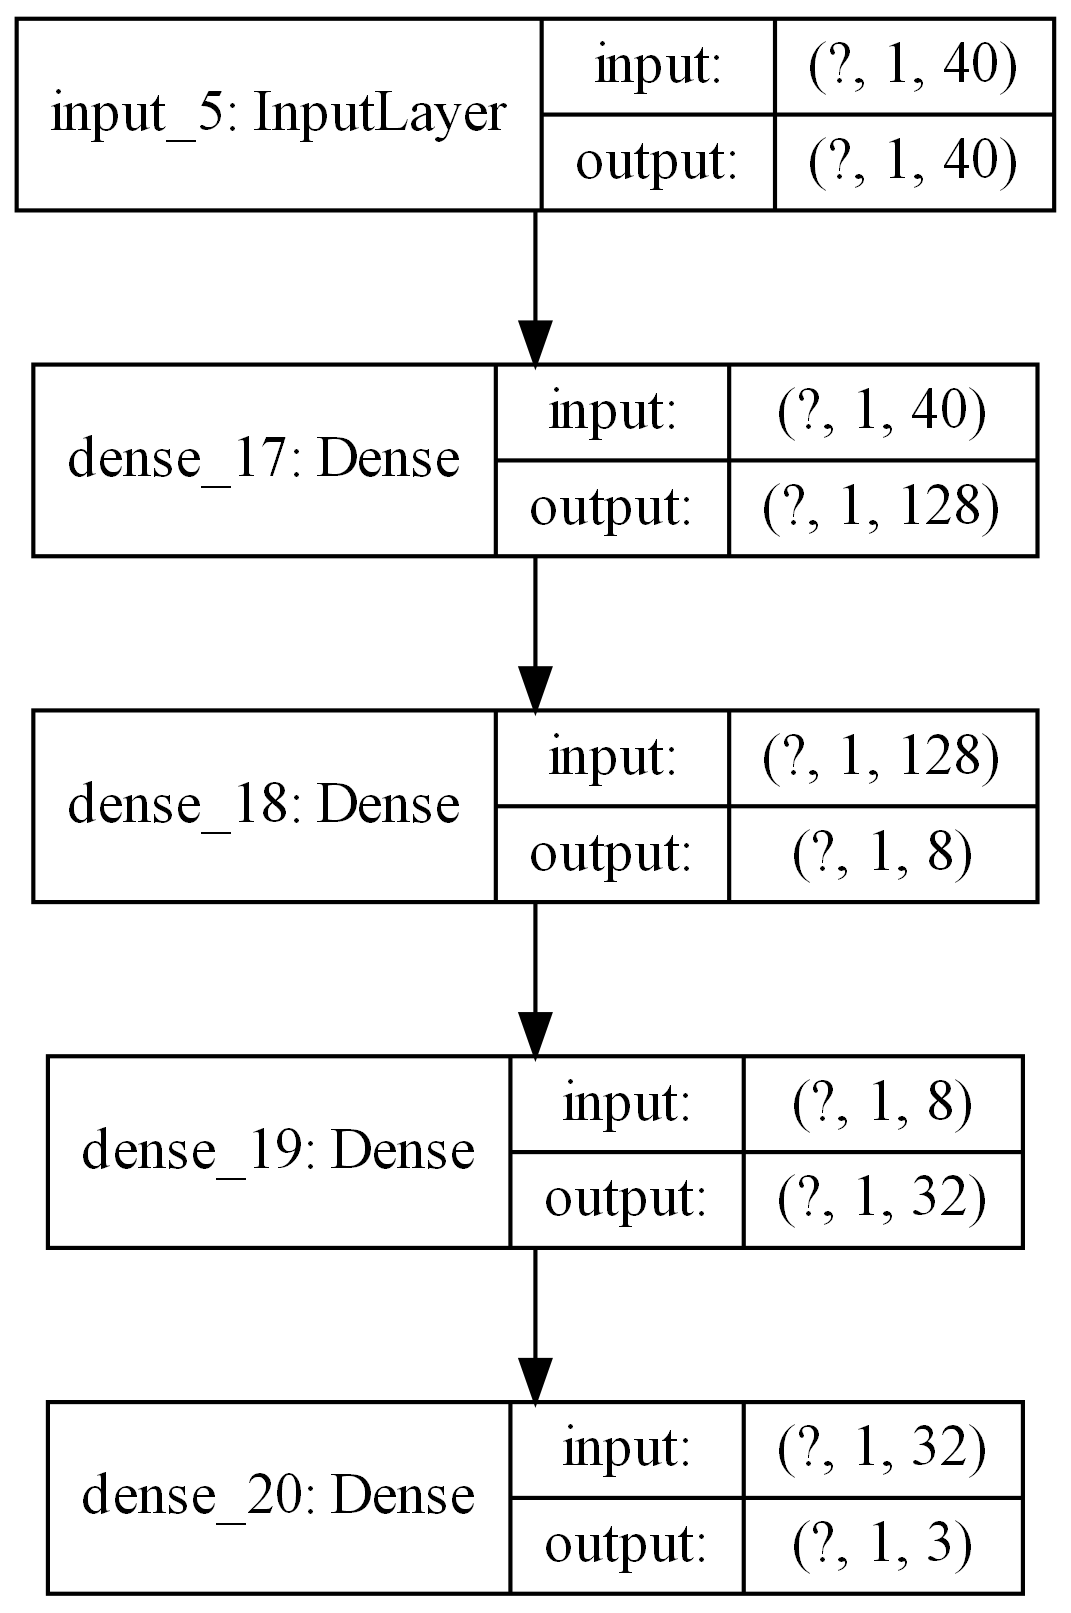

In [59]:
# Model式
lstm_units = 128
dropout = 0.1
pool_size=2

inputs = Input(shape=(1,time_step))

# Dense compasion
model = Dense(128)(inputs) 
model = Dense(8)(model) 
model = Dense(32)(model) 
predictions=Dense(3, activation="elu")(model)  # mape 39

# 多个Dense1输出，效果一般
# predictions=[]
# for i in range(3):
#     x=Dense(1,name='Dense{}'.format(i+1))(model)
#     predictions.append(x)
# predictions = Lambda(lambda x:keras.backend.concatenate(x, axis=2))(predictions)

model = Model(inputs=inputs, outputs=predictions)

# 配置训练模型
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
# 优化器选择：SGD,RMSprop,Adam,AdamW,Adadelta,Adagrad,Adamax,Adafactor,Nadam,Ftrl
model.summary()  # 展示模型结构

plot_model(model, show_shapes=True, show_layer_names=True,to_file='DNN-model.png',dpi=300)  # 展示输入输出表格

In [60]:
#设置回调
# TensorBoard = keras.callbacks.TensorBoard(histogram_freq=1,write_graph=True) # tensorboard --logdir=F:\MATLAB\MATLAB_Scripts\JupyterLab_Projects\logs --host=127.0.0.1

# def scheduler(epoch, lr):
#     if epoch < 5:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
# LearningRateScheduler=keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

# ReduceLROnPlateau=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)  #优化停止时减少学习率
EarlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)  #早停

Train on 4000 samples, validate on 1000 samples
Epoch 1/15
 - 0s - loss: 0.4970 - accuracy: 0.5782 - val_loss: 0.2863 - val_accuracy: 0.6390
Epoch 2/15
 - 0s - loss: 0.2178 - accuracy: 0.6672 - val_loss: 0.1685 - val_accuracy: 0.7580
Epoch 3/15
 - 0s - loss: 0.1417 - accuracy: 0.7232 - val_loss: 0.1196 - val_accuracy: 0.7640
Epoch 4/15
 - 0s - loss: 0.1133 - accuracy: 0.7563 - val_loss: 0.1172 - val_accuracy: 0.7710
Epoch 5/15
 - 0s - loss: 0.1064 - accuracy: 0.7558 - val_loss: 0.1041 - val_accuracy: 0.8030
Epoch 6/15
 - 0s - loss: 0.1047 - accuracy: 0.7598 - val_loss: 0.1125 - val_accuracy: 0.7580
Epoch 7/15
 - 0s - loss: 0.1016 - accuracy: 0.7548 - val_loss: 0.1000 - val_accuracy: 0.7900
Epoch 8/15
 - 0s - loss: 0.1007 - accuracy: 0.7695 - val_loss: 0.1002 - val_accuracy: 0.7920
Epoch 9/15
 - 0s - loss: 0.1027 - accuracy: 0.7615 - val_loss: 0.1194 - val_accuracy: 0.7630
Epoch 10/15
 - 0s - loss: 0.1006 - accuracy: 0.7595 - val_loss: 0.0982 - val_accuracy: 0.8000
Epoch 11/15
 - 0s - l

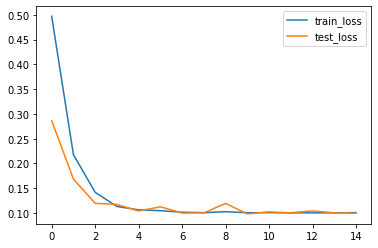

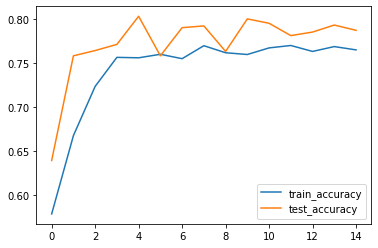

In [61]:
# 训练模型，以 xx 个样本为一个 batch 进行迭代
train = model.fit(
    train_X,
    train_Y,
    epochs=15,
    batch_size=32, # 16 32 64
    validation_data=(test_X, test_Y),
    verbose=2,
    shuffle=True,
    # callbacks=[TensorBoard]
)


# 可视化进度
plt.plot(train.history["loss"], label="train_loss")
plt.plot(train.history["val_loss"], label="test_loss")
plt.legend()
plt.show()

plt.plot(train.history["accuracy"], label="train_accuracy")
plt.plot(train.history["val_accuracy"], label="test_accuracy")
plt.legend()
plt.show()
# %load_ext tensorboard
# %tensorboard --logdir F:\MATLAB\MATLAB_Scripts\JupyterLab_Projects\logs

## 预测光谱数据

In [62]:
# np.save('test_x',test_x)
# from scipy import io
# mat=np.load('test_x.npy')
# io.savemat('test_x.mat', {'test_x': mat})

In [63]:
# 在测试集上的预测
test_Y_predict = model.predict(test_X)
test_Y_predict.shape, test_Y.shape

((1000, 1, 3), (1000, 1, 3))

Text(0.5, 1.0, 'Test Data 1')

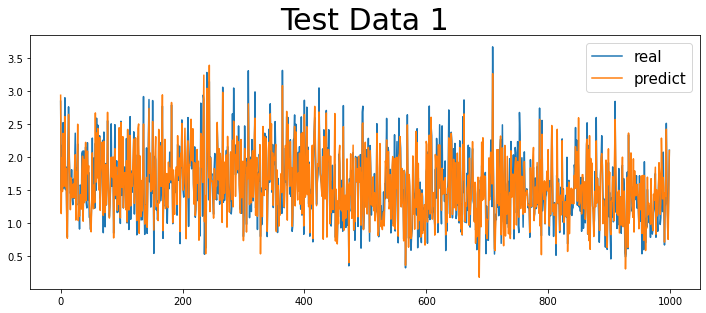

In [64]:
fig = plt.figure(figsize=(16,32))  # 宽，高
fig.subplots_adjust(hspace=0.3, wspace=0.1,top=3)  # 间距
plt.subplot(411)
draw = pd.concat([pd.DataFrame(test_Y[:,0, 0]), pd.DataFrame(test_Y_predict[:,0, 0])], axis=1)
draw.iloc[:, 0].plot(figsize=(12, 6))
draw.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 1", fontsize="30")  # 添加标题

In [65]:
# 输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# 平均绝对误差（Mean Absolute Error，MAE）

# 均方误差（Mean Square Error，MSE）
# 平均绝对百分比误差（Mean Absolute Percentage Error，MAPE）

y=np.squeeze(test_Y_predict)
Y=np.squeeze(test_Y)
print("测试集上的")
print(mean_absolute_error(y,Y))
print(mean_squared_error(y,Y))
print(np.sqrt(mean_squared_error(y,Y)))
print(mape(Y,y))

测试集上的
0.24419755849531954
0.09967347020922616
0.31571105493667173
14.133533063831743
